In [1]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [5]:
print(train_rest_ts[0].shape)

(264, 124)


In [15]:
# Apply PCA

from sklearn.decomposition import PCA

nLat = 60
ntCut = 60

pca = PCA(n_components=nLat)
X_train_pca_inp = np.hstack([subj[:,:ntCut] for subj in train_rest_ts]).T
X_test_pca_inp = np.hstack([subj[:,:ntCut] for subj in test_rest_ts]).T

print(X_train_pca_inp.shape)
print('Done stack')

X_train_pca = pca.fit_transform(X_train_pca_inp)
X_test_pca = pca.transform(X_test_pca_inp)

print(X_train_pca.shape)
print('Done fit transform')

(27960, 264)
Done stack
(27960, 60)
Done fit transform


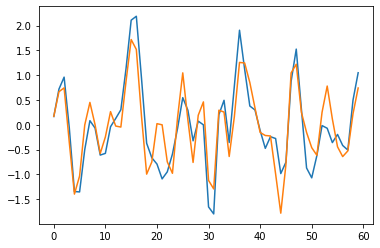

In [17]:
# Validate pca

import matplotlib.pyplot as plt

N = len(train_rest_ts)
nTest = len(test_rest_ts)
nRoi = train_rest_ts[0].shape[0]
nt = ntCut

X_train_pca2 = X_train_pca.reshape([N, -1, nLat])
X_test_pca2 = X_test_pca.reshape([nTest, -1, nLat])

tst = X_test_pca2[0]
tstInv = pca.inverse_transform(tst)

plt.plot(X_test_pca_inp[0:nt,1])
plt.plot(tstInv[0:nt,1])
plt.show()

In [30]:
# Convert to torch

import torch

nWin = 5

# Keys
stk = []
for i in range(nt-nWin+1):
    stk.append(X_train_pca2[:,(i):(i+nWin),:])
stk = np.stack(stk, axis=1)
key_t = torch.from_numpy(stk).float().cuda()

# Values
val_t = torch.from_numpy(X_train[:,0]).float().cuda()
val_t = val_t.unsqueeze(1).expand(N,nt-nWin+1).flatten()

# X_train_t = torch.from_numpy(X_train).float().cuda()
# X_test_t = torch.from_numpy(X_test).float().cuda()

print(key_t.shape)
print('Complete')

torch.Size([466, 56, 5, 60])
Complete


In [73]:
print(val_t[0:3])

tensor([146., 146., 146.], device='cuda:0')


In [59]:
import torch.nn as nn
import torch.nn.functional as F

nHid = 30
nHead = 10

class Att1(nn.Module):
    def __init__(self):
        super(Att1, self).__init__()
        self.qw1 = nn.Parameter(torch.ones(nHead,nWin,nLat).float().cuda())
#         self.qb1 = nn.Parameter(torch.ones(nHead,nWin,nLat).float().cuda())
        self.m = nn.Softmax(dim=1)
        self.fc1 = nn.Linear((nt-nWin+1)*nHead,nHid).cuda()
        self.fc2 = nn.Linear(nHid,1).cuda()
        
    def forward(self, x):
        nB = x.shape[0]
        z = []
        for i in range(nHead):
            q = torch.einsum('abcd,cd->abcd',x,self.qw1[i])
#             q = q + self.qb1[i].unsqueeze(0).unsqueeze(0)
            y = torch.einsum('abcd,efcd->eabf',key_t,q).reshape(nB,N*(nt-nWin+1),nt-nWin+1)
            y /= (nRoi*nWin)**0.5
            y = self.m(y)
            z.append(torch.einsum('abc,b->ac',y,val_t))
        z = torch.cat(z,dim=1)
        x = F.relu(self.fc1(z))
        x = self.fc2(x)
        return x
    
att1 = Att1()
optim = torch.optim.Adam(att1.parameters(), lr=1e-3)
print('Complete')

Complete


In [60]:
import random

running = 0
nEpoch = 1000
pPeriod = 5
nB = 5

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nB).float().cuda()
    for i in range(nB):
        idx = random.randint(0,N-1)
        batch.append(key_t[idx])
        truth[i] = X_train[idx, 0]
    batch = torch.stack(batch)
    optim.zero_grad()
    pred = att1(batch).flatten()
    loss = torch.sum((pred-truth)**2)
    loss.backward()
    running += loss.detach().cpu()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
            else:
                running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, ((running/nB)**0.5)/12))
        running = 0

print('Finished training')

epoch 0 loss=17.386263
epoch 5 loss=8.287677
epoch 10 loss=5.653122
epoch 15 loss=3.614586
epoch 20 loss=3.472034
epoch 25 loss=3.230111
epoch 30 loss=2.864634
epoch 35 loss=3.292370
epoch 40 loss=3.112074
epoch 45 loss=2.970523
epoch 50 loss=3.120931
epoch 55 loss=3.053917
epoch 60 loss=2.688596
epoch 65 loss=2.719018
epoch 70 loss=2.446520
epoch 75 loss=2.659258
epoch 80 loss=2.860085
epoch 85 loss=3.119499
epoch 90 loss=2.309547
epoch 95 loss=3.045760
epoch 100 loss=3.465758
epoch 105 loss=2.877707
epoch 110 loss=3.254181
epoch 115 loss=3.708436
epoch 120 loss=3.409714
epoch 125 loss=3.665736
epoch 130 loss=2.344079
epoch 135 loss=2.262606
epoch 140 loss=2.562213
epoch 145 loss=2.402426
epoch 150 loss=3.804800
epoch 155 loss=3.882531
epoch 160 loss=3.095169
epoch 165 loss=3.166805
epoch 170 loss=2.784223
epoch 175 loss=2.533206
epoch 180 loss=2.903546
epoch 185 loss=2.605499
epoch 190 loss=1.635382
epoch 195 loss=2.106140
epoch 200 loss=2.142551
epoch 205 loss=2.808216
epoch 210 los

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 
[[1.         0.08834914]
 [0.08834914 1.        ]]
3.2272441333328583
2.6325625150631637


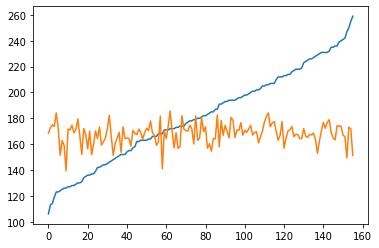

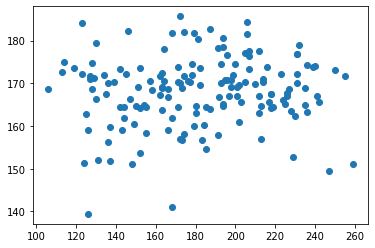

In [61]:
import math

# nB = 5
# N = X_train.shape[0]
# y = X_train[:,0]
# yPred = []
# for i in range(math.ceil(N/nB)):
#     start = i*nB
#     end = (i+1)*nB
#     if end > N:
#         end = N
#     yP = att1(key_t[start:end])
#     yPred.append(yP.flatten().detach().cpu().numpy())
#     print(start, end=' ')
# print()
# yPred = np.hstack(yPred)

nB = 5
N = X_train.shape[0]
NN = X_test.shape[0]
y = X_test[:,0]
yPred = []
for i in range(math.ceil(NN/nB)):
    start = i*nB
    end = (i+1)*nB
    stk = []
    if end > N:
        end = N
    for j in range(nt-nWin+1):
        stk.append(X_test_pca2[start:end,(j):(j+nWin),:])
    stk = np.stack(stk, axis=1)
    key_test_t = torch.from_numpy(stk).float().cuda()
    yP = att1(key_test_t)
    yPred.append(yP.flatten().detach().cpu().numpy())
    print(start, end=' ')
print()
yPred = np.hstack(yPred)
    
idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

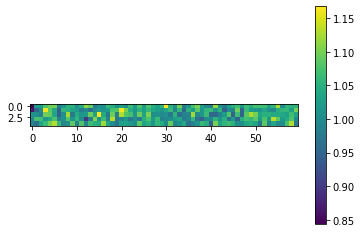

In [72]:
# View head weights

plt.imshow(att1.qw1[9].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [48]:
a = torch.ones(2,2)
print(a[0:0])

tensor([], size=(0, 2))
